In [4]:
import math
from time import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import sklearn as sk
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = sk.preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

In [6]:
df = pd.read_csv('C:/GitHub/kaggle/titanic/data/train.csv', sep=',', header=0)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
def substrings_in_string(whole, subs): 
    
    for x in subs:
        if x in str(whole): 
            return x
        
    return 'Unknown'

In [8]:
def extract_title(full_name):
    
    full_name  = str(full_name)
    
    x = full_name.split(", ")
    x = x[1]
    x = x.split('.')
    x = x[0]
    
    return x

In [9]:
def simplify_titles(x):
    
    title=x['Title']
    
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Dona', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if x['Sex'] == 0:
            return 'Mrs'
        else:
            return 'Mr'
    else:
        return title
    

In [10]:
def preprocess_dataframe(df, prediction_data=False, print_info=False):
    """
    Description:
    
    Performs preprocessing on the titanic data
    
    PassengerId - Id (Only available on training data)
    Survived    - Survived  (0 = No; 1 = Yes)
    Pclass      - Passenger Class  (1 = 1st; 2 = 2nd; 3 = 3rd)
    Name        - Name
    Sex         - Sex
    Age         - Age
    Sibsp       - Number of Siblings/Spouses Aboard
    Parch       - Number of Parents/Children Aboard
    Ticket      - Ticket Number
    Fare        - Passenger Fare (British pound)
    Cabin       - Cabin code
    Embarked    - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
    
    Arguments:
    df -- Dataset, Pandas DataFrame
    
    Returns:
    df -- Dataset, Pandas DataFrame
    """

    # Age has missing values which is replaced with average
    # Might also consider dividing age into classes of age brackets
    df['Age'].fillna((df['Age'].mean()), inplace = True)
    df['Fare'].fillna((df['Fare'].mean()), inplace = True)
    
    # Encode sex into binary (0 = male, 1 = female)
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
    
    # Turning Cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck' ]= df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    # Calculate family size
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Age brackets
    df['AgeBracket'] = df['Age'].apply(lambda x: 'Child' if x <= 10 else ('Adult' if x < 50 else 'Senior'))

    # Extract and process titles
    df['Title']= df['Name'].map(lambda x: extract_title(x))
    if not prediction_data:
        unique_titles = df['Title'].unique()
        survival_by_title = df.groupby('Title').mean()['Survived']
        
    df['Title']=df.apply(simplify_titles, axis=1)
    if not prediction_data:
        unique_titles_simplified = df['Title'].unique()
        survival_by_title_simplified = df.groupby('Title').mean()['Survived']
    

    # Gather info on the significance of these classes for survival
    # Class was, as expected, significance for surival with the rates (1st - 63%, 2nd - 47%, 3rd - 24%)
    # Embarked was suprisingly significant, C - Cherbourg had 55% surivial rate when the mean was just 38%
    if not prediction_data:
        survival_by_plcass = df.groupby('Pclass').mean()['Survived']
        survival_by_deck = df.groupby('Deck').mean()['Survived']
        survival_by_embark = df.groupby('Embarked').mean()['Survived']
        survival_by_familysize = df.groupby('FamilySize').mean()['Survived']
        survival_by_agebracket = df.groupby('AgeBracket').mean()['Survived']
    
    # Split classes with one hot encoding
    # Pclass   - splits into (1 = Pclass_1, 2 = Pclass_2, 3 = Pclass_3)
    # Embarked - splits into (C = Embarked_C, Q = Embarked_Q, S = Embarked_S)
    # Deck - splits into decks with letters
    df = pd.get_dummies(df, columns = ['Pclass', 'Embarked', 'Deck', 'AgeBracket', 'Title'])

    # Drop columns with data deemed not relevant for learning
    # Name     - Gender already has its' own column. Only thing that might be interesting here is the title
    # Ticket   - Ticket does not really say much, price and class are already included which says the most
    # Cabin    - Replaced by Deck
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age'], axis=1) #, 'SibSp', 'Parch'], axis=1)
    
    if prediction_data:
        m = df.shape[0]
        df['Deck_T'] = pd.Series(np.zeros(m, dtype=int), index=df.index)
    
    # Normalize the data
    norm_vals = ['Fare', 'FamilySize', 'SibSp', 'Parch'] #, 'Age']
    df[norm_vals] = (df[norm_vals] - df[norm_vals].min())/(df[norm_vals].max() - df[norm_vals].min())
    
    if print_info:
        if not prediction_data:
            print('--------------------------------------------------------------------------------------')
            print('SURVIVAL RATE')
            print('--------------------------------------------------------------------------------------')
            print('Overall survival rate: ' + str(df['Survived'].mean()))
            print()
            print(survival_by_plcass)
            print()
            print(survival_by_embark)
            print()
            print(survival_by_deck)
            print()
            print(survival_by_title)
            print()
            print(survival_by_title_simplified)
            print()
            print(survival_by_familysize)
            print()
            print(survival_by_agebracket)      
        print('--------------------------------------------------------------------------------------')
        print('TITLES')
        print('--------------------------------------------------------------------------------------')
        print('All titels: ')
        print(unique_titles)
        print()
        print('Simplied titels: ')
        print(unique_titles_simplified)
        print('--------------------------------------------------------------------------------------')
        print('SUMS')
        print('--------------------------------------------------------------------------------------')
        print(df.sum())
        print('--------------------------------------------------------------------------------------')
        print('DATA INFO')
        print('--------------------------------------------------------------------------------------')
        print(df.info())
        print('--------------------------------------------------------------------------------------')
        print('MISSING VALUES')
        print('--------------------------------------------------------------------------------------')
        print(df.isnull().sum())
        print('--------------------------------------------------------------------------------------')
        print('CORRELATIONS')
        print('--------------------------------------------------------------------------------------')
        print(df.corr())
        print('--------------------------------------------------------------------------------------')

    return df

In [11]:
def split_data(df):
    """
    Description:
    Splits the data into test/training set for simple validation

    Arguments:
    df -- Dataset, pandas dataframe
        
    Returns:
    train -- Training samples, pandas dataframe
    test -- Test samples, pandas dataframe
    """

    df_train = df.sample(frac = 0.8, random_state = 42)
    df_test = df.drop(df_train.index)  
    
    X_train = df_train.drop(['Survived'], axis=1).values
    y_train = df_train['Survived'].values
    
    X_test = df_test.drop(['Survived'], axis=1).values
    y_test = df_test['Survived'].values
    
    return X_train, y_train, X_test, y_test

In [12]:
df_processed = preprocess_dataframe(df, False, False)

X_train, y_train, X_test, y_test = split_data(df_processed)

print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

df_processed.head(5)

X_train shape: (713, 27)
y_train shape: (713,)
X_test shape: (178, 27)
y_test shape: (178,)


,Survived,Sex,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,Deck_G,Deck_T,Deck_Unknown,AgeBracket_Adult,AgeBracket_Child,AgeBracket_Senior,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,0,0.125,0.0,0.014151,0.1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
1,1,1,0.125,0.0,0.139136,0.1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,1,0.000,0.0,0.015469,0.0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
3,1,1,0.125,0.0,0.103644,0.1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0.000,0.0,0.015713,0.0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0


In [13]:
def decision_tree_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a decision tree classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    dt_clf -- Classifier, sklearn DecisionTreeClassifier
    """
    
    dt_clf = sk.tree.DecisionTreeClassifier(max_depth=20)
    dt_clf.fit (X_train, y_train)
    print(dt_clf.score (X_test, y_test))
    
    return dt_clf

In [14]:
dt_clf = decision_tree_clf(X_train, y_train, X_test, y_test)

0.8089887640449438


In [15]:
def random_forest_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a random forest classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    rf_clf -- Classifier, sklearn RandomForestClassifier
    """
    
    rf_clf = ske.RandomForestClassifier(n_estimators=50)
    rf_clf.fit (X_train, y_train)
    print(rf_clf.score (X_test, y_test))
    
    return rf_clf

In [16]:
rf_clf = random_forest_clf(X_train, y_train, X_test, y_test)

0.8202247191011236


In [17]:
def gradient_boosting_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a gradient boosting classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    gb_clf -- Classifier, sklearn GradiantBoostingClassifier
    """
    
    gb_clf = ske.GradientBoostingClassifier(n_estimators=50)
    gb_clf.fit (X_train, y_train)
    print(gb_clf.score (X_test, y_test))
    
    return gb_clf

In [18]:
gb_clf = gradient_boosting_clf(X_train, y_train, X_test, y_test) 

0.848314606741573


In [19]:
def logistic_regression_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a logistic regression classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    rf_clf -- Classifier, sklearn LogisticRegression
    """
    
    lr_clf = LogisticRegression()
    lr_clf.fit (X_train, y_train)
    print(lr_clf.score (X_test, y_test))
    
    return lr_clf

In [20]:
lr_clf = logistic_regression_clf(X_train, y_train, X_test, y_test)

0.8370786516853933


In [21]:
def support_vector_machine_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a support vector machine classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn SVC
    """
    
    svm_clf = sk.svm.SVC(probability=True)
    svm_clf.fit (X_train, y_train)
    print(svm_clf.score (X_test, y_test))
    
    return svm_clf

In [22]:
svm_clf = support_vector_machine_clf(X_train, y_train, X_test, y_test) 

0.8258426966292135


In [23]:
def naive_bayes_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a gaussian naive bayes classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn GaussianNB
    """
    
    nb_clf = GaussianNB()
    nb_clf.fit (X_train, y_train)
    print(nb_clf.score (X_test, y_test))
    
    return nb_clf

In [24]:
nb_clf = naive_bayes_clf(X_train, y_train, X_test, y_test)

0.7247191011235955


In [25]:
def k_neighbors_clf(X_train, y_train, X_test, y_test):
    """
    Description:
    Builds and trains a k-nearest neighbors classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn KNeighborsClassifier
    """
    
    knn_clf = KNeighborsClassifier(n_neighbors=6)
    knn_clf.fit (X_train, y_train)
    print(knn_clf.score (X_test, y_test))
    
    return knn_clf

In [26]:
knn_clf = k_neighbors_clf(X_train, y_train, X_test, y_test)

0.8146067415730337


In [27]:
def ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, cv=20, score_individually=False):
    """
    Description:
    Builds and trains an ensamble of classifiers which them vote together

    Arguments:
    clfs -- Classifiers with labels, List Tuple(String, clf)
    
    Returns:
    e_clf -- Classifier, sklearn VotingClassifier
    """
    
    e_clf = ske.VotingClassifier(estimators=clfs, voting='hard') # Hard voting where majority rules
    e_clf.fit (X_train, y_train)
    
    if score_individually:
        for label, clf in clfs:
            scores = cross_val_score(clf, X_test, y_test, cv=cv, scoring='accuracy')
            print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    
    
    scores = cross_val_score(e_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Voting Ensamble')) 
    
    return e_clf    

In [28]:
clfs = ([('Decision Tree', dt_clf), ('Random Forest', rf_clf), ('Gradiant Boosting', gb_clf), 
         ('Logistic Regression', lr_clf), ('SVM', svm_clf), ('Naive Bayes', nb_clf), ('K-Nearest', knn_clf)])

e_clf = ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, score_individually=True)

Accuracy: 0.81 (+/- 0.11) [Decision Tree]
Accuracy: 0.83 (+/- 0.09) [Random Forest]
Accuracy: 0.83 (+/- 0.11) [Gradiant Boosting]
Accuracy: 0.84 (+/- 0.11) [Logistic Regression]
Accuracy: 0.81 (+/- 0.10) [SVM]
Accuracy: 0.70 (+/- 0.17) [Naive Bayes]
Accuracy: 0.81 (+/- 0.11) [K-Nearest]
Accuracy: 0.85 (+/- 0.09) [Voting Ensamble]


In [29]:
def predict(df, clf, export_path):
    """
    Description:
    Makes predictions X -> y and exports to csv

    Arguments:
    df -- Data to predict from, pandas DataFrame
    clf -- classifier, Classifier, sklearn classifier object
    export_path -- Path and name of file, String
        
    Returns:
    df_pred -- prediction, pandas DataFrame
    """
    
    # Extract Ids
    y1 = df['PassengerId'].values
    
    # Make predictions
    df_process = preprocess_dataframe(df, prediction_data=True, print_info=False) 
    X = df_process.values
    y2 = clf.predict(X)
    
    # Combine ids and predictions
    y = np.column_stack((y1, y2))
    
    # Restore pandas df
    df_pred = pd.DataFrame(y)
    df_pred.columns = ["PassengerId", "Survived"]
    
    # Export
    df_pred.to_csv(export_path, sep=',', index=False)
    
    return df_pred

In [30]:
df_pred = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_pred = predict(df_pred, rf_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_random_forest.csv')
df_pred.head(5)

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,0
4,896,0


In [31]:
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [58]:
def random_search_hyperparameters(clf, hyper_param, X_train, y_train, X_test, y_test, print_result=False):
    
    # run randomized search
    n_iter_search = 10
    rnd_clf = RandomizedSearchCV(clf, param_distributions=hyper_param, n_iter=n_iter_search)

    start = time()
    rnd_clf.fit(X_train, y_train)
    
    if print_result:
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
        report(rnd_clf.cv_results_)
        y_true, y_pred = y_test, clf.predict(X_test)
        scores = cross_val_score(clf, X_test, y_test, cv=20, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_true, y_pred))
       
    return rnd_clf  

In [59]:
def grid_search_hyperparameters(clf, hyper_param, X_train, y_train, X_test, y_test, print_result=False):
    
    # run grid search
    grid_clf = GridSearchCV(clf, param_grid=hyper_param)
    start = time()
    grid_clf.fit(X_train, y_train)
    
    if print_result:
        report(grid_clf.cv_results_)
        y_true, y_pred = y_test, clf.predict(X_test)
        scores = cross_val_score(clf, X_test, y_test, cv=20, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_true, y_pred))
    
    return grid_clf  

In [56]:
# specify parameters and distributions to sample from
hyper_param = {"max_depth": [3, None],
               "max_features": stats.randint(3, X_train.shape[1]),
               "min_samples_split": stats.randint(2, 11),
               "min_samples_leaf": stats.randint(1, 11),
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rnd_rf_clf = random_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_test, y_test)

In [57]:
# use a full grid over all parameters
hyper_param = {"max_depth": [3, None],
               "max_features": [3, 10, X_train.shape[1]],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rf_grid_clf = grid_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.833 (std: 0.012)
Parameters: {'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'max_features': 10, 'min_samples_split': 2, 'max_depth': None}

Accuracy: 0.80 (+/- 0.10)
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       113
          1       0.75      0.75      0.75        65

avg / total       0.82      0.82      0.82       178



In [60]:
# specify parameters and distributions to sample from
hyper_param = {'C': stats.randint(10, 10000),
               'gamma' : stats.uniform(0.001, 1),
               'kernel': ['rbf']}

svm_rnd_clf = random_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_test, y_test)

In [61]:
# use a full grid over all parameters
hyper_param = {'C': [10, 100, 1000, 10000], 
               'gamma' : [0.001, 0.01, 0.1, 1], 
               'kernel': ['rbf']}

svm_grid_clf = grid_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.822 (std: 0.018)
Parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 0.1}

Model with rank: 1
Mean validation score: 0.822 (std: 0.006)
Parameters: {'C': 10000, 'kernel': 'rbf', 'gamma': 0.001}

Accuracy: 0.81 (+/- 0.10)

             precision    recall  f1-score   support

          0       0.86      0.87      0.86       113
          1       0.77      0.75      0.76        65

avg / total       0.83      0.83      0.83       178



In [62]:
# specify parameters and distributions to sample from
hyper_param = {'penalty': ['l1','l2'], 
               'C': stats.uniform(0.001,1000)}

lr_rnd_clf = random_search_hyperparameters(lr_clf, hyper_param, X_train, y_train, X_test, y_test)

In [63]:
# use a full grid over all parameters
hyper_param = {'penalty': ['l1','l2'], 
               'C': [0.001,0.01,0.1,1,10,100,1000]}

lr_grid_clf = grid_search_hyperparameters(lr_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.818 (std: 0.007)
Parameters: {'penalty': 'l2', 'C': 10}

Accuracy: 0.84 (+/- 0.11)

             precision    recall  f1-score   support

          0       0.88      0.87      0.87       113
          1       0.77      0.78      0.78        65

avg / total       0.84      0.84      0.84       178



In [40]:
clfs = ([('Grid Random Forest', rf_grid_clf), ('Grid SVM', svm_grid_clf), ('Grid Logistic Regression', lr_grid_clf)])

e_grid_clf = ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, score_individually=False, cv=5)

Accuracy: 0.80 (+/- 0.06) [Voting Ensamble]


In [64]:
df_pred = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_pred = predict(df_pred, lr_grid_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_tuned_logistic_regression.csv')
df_pred.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0


In [245]:
def create_model(paramters):
    
    num_features = parameters['num_features']
    X = tf.placeholder(tf.float32, [None, num_features], name='X')
    y = tf.placeholder(tf.float32, [None, 1], name='y')

    layers_dim = paramters['layers_dim']
    
    fc = tf.contrib.layers.stack(X, tf.contrib.layers.fully_connected, layers_dim)
    Z = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None, scope='Z')
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=y, name='Loss')
    cost = tf.reduce_mean(loss, name='Cost')
    
    learning_rate = parameters['learning_rate']
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    prediction = tf.round(tf.sigmoid(Z))
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model = {'X': X, 'y': y, 'Z': Z, 'cost': cost,
             'train_op': train_op, 'prediction': prediction, 'accuracy': accuracy}
    
    return model

In [246]:
def random_mini_batches(X_train, Y_train, mini_batch_size = 32, seed = 0):
 
    # Shuffle with identical seed to get same shuffle in both X and Y
    np.random.seed(seed)
    X_train = np.random.permutation(X_train)
    
    np.random.seed(seed)
    Y_train = np.random.permutation(Y_train)
    
    m = X_train.shape[0]
    num_batches = int(m / mini_batch_size)
    
    # Split data into smaller batches for ready for stochastic gradient descent
    minibatches_X = np.array_split(X_train, num_batches)
    minibatches_Y = np.array_split(Y_train, num_batches)
    
    minibatches = zip(minibatches_X, minibatches_Y)
    
    return minibatches

In [254]:
def train_model(parameters, model):
    
    num_epochs = parameters['num_epochs']
    minibatch_size = parameters['minibatch_size']
    X_train = parameters['X_train']
    y_train = parameters['y_train']
    
    
    train_size = X_train.shape[0]
    saver = tf.train.Saver()
    epoch_list = []
    cost_list = []
    
    with tf.Session() as sess:
        
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(train_size / minibatch_size)
            minibatches = random_mini_batches(X_train, y_train, minibatch_size)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_y) = minibatch
                minibatch_y = np.reshape(minibatch_y, (minibatch_X.shape[0], 1))
                feed_dict = {model['X'] : minibatch_X, model['y'] : minibatch_y}

                _model ,minibatch_cost = sess.run([model['train_op'], model['cost']], feed_dict= feed_dict)
                epoch_cost += minibatch_cost / num_minibatches
            
            if parameters['print'] and (epoch % parameters['print_freq'] == 0):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            if parameters['save_cost'] and (epoch % parameters['save_cost_freq'] == 0):
                epoch_list.append(epoch)
                cost_list.append(epoch_cost)
                
        saver.save(sess, parameters['save_path'])
        
    return {'epoch_list': epoch_list, 'cost_list' : cost_list}

In [255]:
parameters = {}

# set model parameters
parameters['X_train'] = X_train
parameters['y_train'] = y_train
parameters['X_test'] = X_test
parameters['y_test'] = y_test
parameters['layers_dim'] = [14]
parameters['num_features'] = X_train.shape[1]
parameters['layers_dim'] = [14]
parameters['learning_rate'] = 0.01

# set train parameters (hyper parameter)
parameters['num_epochs'] = 3000
parameters['minibatch_size'] = 20

# set option parameters
parameters['model_name'] = 'nn_clf'
parameters['save_path'] = 'C:/GitHub/kaggle/titanic/models/' + parameters['model_name']
parameters['print'] = True
parameters['print_freq'] = 500
parameters['save_cost'] = True
parameters['save_cost_freq'] = 10

In [256]:
with tf.Graph().as_default():
    model = create_model(parameters)
    plot_data = train_model(parameters, model)

Cost after epoch 0: 0.556942
Cost after epoch 500: 0.302037
Cost after epoch 1000: 0.297273
Cost after epoch 1500: 0.293644
Cost after epoch 2000: 0.292970
Cost after epoch 2500: 0.290712


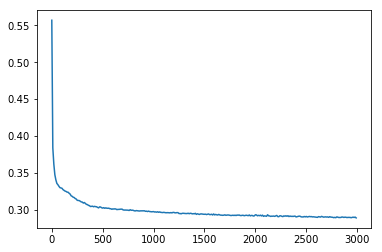

In [257]:
import matplotlib.pyplot as plt
%matplotlib inline
print
if parameters['save_cost']:
    plt.plot(plot_data['epoch_list'], plot_data['cost_list'])

In [266]:
def evaluate(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['save_path'])
        print ("Train Accuracy:", model['accuracy'].eval({model['X']: X_train, 
                                                          model['y']: np.reshape(y_train, (X_train.shape[0], 1)) }))
        print ("Valid Accuracy:", model['accuracy'].eval({model['X']: X_test, 
                                                          model['y']: np.reshape(y_test, (X_test.shape[0], 1)) }))

In [267]:
with tf.Graph().as_default():
    model = create_model(parameters)
    evaluate(parameters, model)

INFO:tensorflow:Restoring parameters from C:/GitHub/kaggle/titanic/models/nn_clf
Train Accuracy: 0.87798035
Valid Accuracy: 0.8258427


In [269]:
def predict_nn(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['model_name']) 
        return model['prediction'].eval({model['X']: X_test})

In [ ]:
answer = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
with tf.Graph().as_default():
    model = create_model(parameters)
    y_pred = predict_nn(parameters, model)
    answer['Survived'] = y_pred.astype(int)
    
    # Extract Ids
    y1 = df['PassengerId'].values
    
    # Make predictions
    df_process = preprocess_dataframe(df, prediction_data=True, print_info=False) 
    X = df_process.values
    y2 = clf.predict(X)
    
    # Combine ids and predictions
    y = np.column_stack((y1, y2))
    
    # Restore pandas df
    df_pred = pd.DataFrame(y)
    df_pred.columns = ["PassengerId", "Survived"]
    
    # Export
    df_pred.to_csv(export_path, sep=',', index=False)